<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/03_Evaluate_1B_CARBON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-1B Evaluation
## 03 - Measuring Environmental Impact & Inference Performance

### Exploring energy efficiency of width-pruned GLU models
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** GPU L4 (or T4)

**Models to Profile:**
- Llama-3.2-1B (baseline)
- Llama-3.2-1B-pruned-40%

**Workloads (2 representative):**
- GSM8K: Math reasoning (100 prompts, 100 max tokens)
- MMLU: Knowledge QA (100 prompts, 50 max tokens)

**Metrics Collected:**
- Energy consumption (kWh via CodeCarbon)
- Throughput (tokens/second)
- Latency (TTFT - Time To First Token)
- Memory footprint (GPU allocation)

**Estimated Runtime:** ~1-2 hours total

---

## 📋 Notebook Objective

This notebook conducts a comprehensive evaluation of the Llama-3.2-1B model family across three pruning levels (20%, 40%, 60%) to determine:

1. **Performance degradation patterns** across different pruning intensities
2. **Optimal expansion ratio** for GLU-MLP layers (hypothesis: 140%)
3. **Task-specific resilience** to pruning (knowledge vs. algorithmic tasks)
4. **Which models merit uploading to HuggingFace Hub** for Phase 2

### Key Features:
- ✅ **Checkpoint/Resume Support:** Survives Colab disconnections
- ✅ **On-the-fly Pruning:** No need to pre-create models
- ✅ **Robust Error Handling:** Continues if individual benchmarks fail
- ✅ **Progress Tracking:** Live updates and detailed logging

### Results will answer:
- Does 40% pruning (140% expansion) truly outperform other levels?
- Which benchmarks are most sensitive to pruning?
- Should we upload non-star models to HF, or only the 40% version?

---

**Note:** This evaluation uses the MAW (Maximum Absolute Weight) neuron selection method, validated in Notebook 00 as the optimal approach for GLU architectures.

---

# 1. Setup & Installation

In [1]:
# Install required libraries
!pip install -q optipfair
!pip install -q lm-eval
!pip install -q langdetect
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Mount Google Drive for checkpoint persistence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

✅ utils.py downloaded successfully


In [4]:
# Import core libraries and utilities
import torch
import json
import pandas as pd
from datetime import datetime
from pathlib import Path
import glob
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

# Import our utility functions
from utils import (
    EXPERIMENT_CONFIG_CARBON,
    BENCHMARKS_CARBON,
    load_or_create_model,
    run_carbon_profiling,
    run_robust_evaluation,
    clear_gpu_cache,
    get_model_stats,
    format_results_table,
    calibrate_idle_power  # ← NUEVA FUNCIÓN
)

print("✅ All imports successful")
print(f"📱 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All imports successful
📱 Device: GPU
   GPU: NVIDIA L4
   Memory: 23.8 GB


In [5]:
# =============================================================================
# EXPERIMENTAL RUNS CONFIGURATION
# =============================================================================
NUM_EXPERIMENTAL_RUNS = 3
RANDOM_SEEDS = [42, 123, 456]  # Fixed seeds for reproducibility

print(f"🔄 Experiment Configuration:")
print(f"   Number of runs: {NUM_EXPERIMENTAL_RUNS}")
print(f"   Random seeds: {RANDOM_SEEDS}")
print(f"   Total evaluations per model: {len(BENCHMARKS_CARBON)} workloads × {NUM_EXPERIMENTAL_RUNS} runs")
print()

🔄 Experiment Configuration:
   Number of runs: 3
   Random seeds: [42, 123, 456]
   Total evaluations per model: 6 workloads × 3 runs



# 2. Configuration & Planning

This section filters the experiment configuration for 1B models and displays the profiling plan.

In [6]:
# Filter configuration for 1B models only
models_1b = [
    config for config in EXPERIMENT_CONFIG_CARBON
    if "1B" in config["base_model"] and "3B" not in config["base_model"] and "Instruct" not in config["base_model"]
]

print(f"\n{'='*70}")
print("📊 EVALUATION PLAN: Llama-3.2-1B Family")
print(f"{'='*70}\n")

print(f"Total models to evaluate: {len(models_1b) + 1}")  # +1 for base model
print(f"Benchmarks per model: {len(BENCHMARKS_CARBON)}")
print(f"Total evaluations: {(len(models_1b) + 1) * len(BENCHMARKS_CARBON)}")
print(f"Estimated runtime: ~1-1.5 hours\n")

# Display models table
print("Models to profile:")
print("-" * 70)
print(f"{'Model':<40} {'Pruning':<10} {'Star':<6}")
print("-" * 70)

for config in models_1b:
    if config['pruning_pct'] == 0:
        model_name = "Llama-3.2-1B (baseline)"
    else:
        model_name = f"Llama-3.2-1B-pruned-{config['pruning_pct']}%"

    pruning = f"{config['pruning_pct']}%"
    star = "⭐ Yes" if config['is_star'] else "No"
    print(f"{model_name:<40} {pruning:<10} {star:<6}")

print("-" * 70)

# Display workloads
print("\nWorkloads to run:")
print("-" * 70)
for i, workload in enumerate(BENCHMARKS_CARBON, 1):
    name = workload['name']
    prompts = workload['num_prompts']
    tokens = workload['max_new_tokens']
    desc = workload['description']
    print(f"{i}. {name:<25} {prompts} prompts, {tokens} tokens - {desc}")
print("-" * 70)

print("\n⚙️ Configuration:")
print(f"   - Neuron selection method: MAW (Maximum Absolute Weight)")
print(f"   - Checkpointing: Enabled (per-workload granularity)")
print(f"   - Model creation: On-the-fly pruning (no pre-creation needed)")
print(f"   - GPU warm-up: First 5 prompts excluded from metrics")
print(f"   - Energy tracking: CodeCarbon")


📊 EVALUATION PLAN: Llama-3.2-1B Family

Total models to evaluate: 8
Benchmarks per model: 6
Total evaluations: 48
Estimated runtime: ~1-1.5 hours

Models to profile:
----------------------------------------------------------------------
Model                                    Pruning    Star  
----------------------------------------------------------------------
Llama-3.2-1B (baseline)                  0%         No    
Llama-3.2-1B-pruned-10%                  10%        No    
Llama-3.2-1B-pruned-20%                  20%        No    
Llama-3.2-1B-pruned-30%                  30%        No    
Llama-3.2-1B-pruned-40%                  40%        ⭐ Yes 
Llama-3.2-1B-pruned-50%                  50%        No    
Llama-3.2-1B-pruned-60%                  60%        No    
----------------------------------------------------------------------

Workloads to run:
----------------------------------------------------------------------
1. gsm8k_latency_b1          10 prompts, 100 tokens - Math

In [7]:
# Setup checkpoint paths (manual construction since helpers are internal)
BASE_CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints"
RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

# Carbon-specific subdirectory
CHECKPOINT_DIR = f"{BASE_CHECKPOINT_DIR}/1b_carbon"

# Create directories if they don't exist
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

print(f"✅ Checkpoint directory: {CHECKPOINT_DIR}")
print(f"✅ Results directory: {RESULTS_DIR}")

# ============================================================================
# CONSTRUCT CHECKPOINT PATHS DYNAMICALLY FROM models_1b
# ============================================================================
checkpoint_paths = {}

for config in models_1b:
    pruning_pct = config['pruning_pct']

    # Create key: "baseline" for 0%, "{X}pct" for others
    if pruning_pct == 0:
        key = "baseline"
        filename = "llama_3.2_1b_baseline_carbon.json"
    else:
        key = f"{pruning_pct}pct"
        filename = f"llama_3.2_1b_pruned_{pruning_pct}pct_carbon.json"

    checkpoint_paths[key] = f"{CHECKPOINT_DIR}/{filename}"

print(f"\n📂 Auto-generated {len(checkpoint_paths)} checkpoint paths:")
for key, path in checkpoint_paths.items():
    exists = "✅ Exists" if Path(path).exists() else "🆕 New"
    print(f"  {key:<10}: {exists}")

✅ Checkpoint directory: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon
✅ Results directory: /content/drive/MyDrive/glu_pruning/results

📂 Auto-generated 7 checkpoint paths:
  baseline  : 🆕 New
  10pct     : 🆕 New
  20pct     : 🆕 New
  30pct     : 🆕 New
  40pct     : 🆕 New
  50pct     : 🆕 New
  60pct     : 🆕 New


# 3. Baseline Evaluation

Evaluate the original Llama-3.2-1B model to establish performance baseline.

In [8]:
# ====================================================================
# CALIBRATE IDLE POWER (Run once at start)
# ====================================================================
print("="*70)
print("🔋 STEP 0: IDLE POWER CALIBRATION")
print("="*70 + "\n")

idle_calibration = calibrate_idle_power(
    device="cuda",
    duration_seconds=30,  # 30s is enough for stable measurement
    verbose=True
)

# Save calibration to drive for reproducibility
calibration_path = f"{RESULTS_DIR}/idle_power_calibration.json"
with open(calibration_path, 'w') as f:
    json.dump(idle_calibration, f, indent=2)

print(f"\n💾 Calibration saved to: {calibration_path}")
print("="*70 + "\n")

[codecarbon WARNING @ 21:16:30] Multiple instances of codecarbon are allowed to run at the same time.


🔋 STEP 0: IDLE POWER CALIBRATION

🔋 Starting idle power calibration (30s)...
   Clearing GPU cache...
   Measuring idle power for 30s...
✅ Calibration complete!
   Idle Power: 31.22 W
   Idle Energy (30s): 0.000260 kWh
   GPU Temperature: 39.0°C

💾 Calibration saved to: /content/drive/MyDrive/glu_pruning/results/idle_power_calibration.json



In [ ]:
print(f"\n{'='*70}")
print("📊  PHASE 1: BASELINE PROFILING")
print(f"{'='*70}\n")

BASE_MODEL_ID = "meta-llama/Llama-3.2-1B"

# ============================================================================
# MULTIPLE RUNS LOOP FOR BASELINE
# ============================================================================
baseline_all_runs = {}  # Store results from all runs

for run_idx, seed in enumerate(RANDOM_SEEDS, 1):
    print(f"\n{''*70}")
    print(f"🔄  BASELINE - RUN {run_idx}/{NUM_EXPERIMENTAL_RUNS} (seed={seed})")
    print(f"{'─'*70}\n")

    # Load base model (fresh for each run to avoid state contamination)
    print(f"Loading base model: {BASE_MODEL_ID}...")
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_ID,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    print("✅  Model loaded successfully")

    # Construct checkpoint path for this run
    checkpoint_path_run = checkpoint_paths["baseline"].replace(".json", f"_run{run_idx}_seed{seed}.json")

    # Run carbon profiling with seed
    baseline_results_run = run_carbon_profiling(
        model=base_model,
        tokenizer=tokenizer,
        workloads=BENCHMARKS_CARBON,
        checkpoint_path=checkpoint_path_run,
        model_name=f"Llama-3.2-1B-baseline-run{run_idx}",
        idle_power_calibration=idle_calibration,  # ← CAMBIO: usar None
        device="cuda",
        random_seed=seed  # ← NUEVO: pasar seed
    )

    # Store results for this run
    baseline_all_runs[f"run_{run_idx}"] = baseline_results_run

    # Display run summary
    print(f"\n✅ Run {run_idx} completed")
    print("Results summary:")
    for workload_name, metrics in baseline_results_run.items():
        print(f"\n{workload_name}:")
        print(f"  Energy: {metrics['energy_kwh']:.6f} kWh")
        print(f"  Throughput: {metrics['throughput_tokens_per_sec']:.2f} tok/s")

    # Clear memory before next run
    del base_model
    clear_gpu_cache()
    print(f"🧹  Memory cleared\n")

print(f"\n{'='*70}")
print("✅  ALL BASELINE RUNS COMPLETED")
print(f"{'='*70}\n")

# 4. Pruned Models Evaluation Loop

Profile the pruned variants using on-the-fly pruning with OptiPFair.

In [ ]:
print(f"\n{'='*70}")
print("📊  PHASE 2: PRUNED MODELS PROFILING")
print(f"{'='*70}\n")

# Store all results for final comparison
# Structure: all_results[model_key][run_key] = results_dict
all_results = {
    "baseline": baseline_all_runs  # ← CAMBIO: ahora contiene múltiples runs
}

# Filter out baseline (already done)
pruned_models = [m for m in models_1b if m['pruning_pct'] > 0]

# Evaluate each pruned model
for i, config in enumerate(pruned_models, 1):
    model_name = f"Llama-3.2-1B-pruned-{config['pruning_pct']}%"
    pruning_pct = config['pruning_pct']
    is_star = config['is_star']

    print(f"\n{'─'*70}")
    print(f"🔄  PROFILING MODEL {i}/{len(pruned_models)}: {model_name}")
    print(f"   Pruning: {pruning_pct}% | Star: {'⭐ ' if is_star else '❌'}")
    print(f"{'─'*70}\n")

    # ========================================================================
    # MULTIPLE RUNS LOOP FOR THIS PRUNED MODEL
    # ========================================================================
    pruned_model_all_runs = {}

    for run_idx, seed in enumerate(RANDOM_SEEDS, 1):
        print(f"\n{'··'*35}")
        print(f"   RUN {run_idx}/{NUM_EXPERIMENTAL_RUNS} (seed={seed})")
        print(f"{'··'*35}\n")

        try:
            # Load or create model (fresh for each run)
            model, tokenizer, stats = load_or_create_model(config, device="cuda")

            # Display model statistics (once per model, not per run)
            if run_idx == 1:
                print(f"\n📈  Model Statistics:")
                print(f"   Parameters: {stats['total_parameters']:,}")
                print(f"   Size: {stats['size_gb']:.2f} GB")
                if 'pruning_stats' in stats:
                    print(f"   Reduction: {stats['pruning_stats']['percentage_reduction']:.1f}%")
                print(f"   Source: {stats['source']}\n")

            # Construct checkpoint path for this run
            checkpoint_key = f"{pruning_pct}pct"
            checkpoint_path_run = checkpoint_paths[checkpoint_key].replace(".json", f"_run{run_idx}_seed{seed}.json")

            # Run profiling with seed
            results_run = run_carbon_profiling(
                model=model,
                tokenizer=tokenizer,
                workloads=BENCHMARKS_CARBON,
                checkpoint_path=checkpoint_path_run,
                model_name=f"{model_name}-run{run_idx}",
                idle_power_calibration=idle_calibration,  # ← CAMBIO: usar None
                device="cuda",
                random_seed=seed  # ← NUEVO: pasar seed
            )

            # Store results for this run
            pruned_model_all_runs[f"run_{run_idx}"] = results_run

            print(f"\n✅ Run {run_idx} completed for {model_name}")

            # Clear memory before next run
            del model
            clear_gpu_cache()

        except Exception as e:
            print(f"\n❌  ERROR in run {run_idx}: {str(e)}")
            import traceback
            traceback.print_exc()
            clear_gpu_cache()
            continue

    # Store all runs for this model
    all_results[checkpoint_key] = pruned_model_all_runs

    print(f"\n✅ All runs completed for {model_name}\n")

print(f"\n{'='*70}")
print("✅  ALL MODELS PROFILED")
print(f"{'='*70}\n")

In [11]:
# ===========================================================================
# CREATE GLOBAL MAPPINGS (FOR LATER CELLS)
# ===========================================================================
# These dicts are used by cells 17, 18, and 21 for aggregation and display.

model_names = {}
model_pruning = {}
model_is_star = {}

print("\n🛠️  Creating global model mappings (model_names, model_pruning, model_is_star)...")

for config in models_1b:
    pruning_pct = config['pruning_pct']

    # Determine the key (must match Cell 10's logic: 'baseline' or '40pct')
    if pruning_pct == 0:
        key = "baseline"
        model_name = "Llama-3.2-1B (baseline)"
    else:
        key = f"{pruning_pct}pct"
        model_name = f"Llama-3.2-1B-pruned-{pruning_pct}%"

    # Populate the dictionaries
    model_names[key] = model_name
    model_pruning[key] = pruning_pct
    model_is_star[key] = config['is_star']

print(f"   ...Mappings created for {len(model_names)} models: {list(model_names.keys())}")


🛠️  Creating global model mappings (model_names, model_pruning, model_is_star)...
   ...Mappings created for 7 models: ['baseline', '10pct', '20pct', '30pct', '40pct', '50pct', '60pct']


# 5. Results Consolidation & Export

Consolidate all evaluation results and export to CSV for analysis.

In [19]:
print(f"\n{'='*70}")
print("📊  AGGREGATING RESULTS ACROSS RUNS")
print(f"{'='*70}\n")
JOULES_THRESHOLD = 0.21 # Umbral: 50 mJ/token

def aggregate_runs(runs_dict):
    """
    Aggregate metrics from multiple runs.
    ...
    """
    import numpy as np

    aggregated = {}

    # --- INICIO CORRECCIÓN: Manejar runs vacíos ---
    # Get workload names from first *valid* run
    first_valid_run_key = next((key for key, val in runs_dict.items() if val), None)
    if not first_valid_run_key:
        print("    ⚠️ Error: All runs dictionaries are empty. No data to aggregate.")
        return {}

    first_run = runs_dict[first_valid_run_key]
    workload_names = list(first_run.keys())
    # --- FIN CORRECCIÓN ---

    for workload_name in workload_names:
        # Extract metrics across all runs
        energy_samples = []
        throughput_samples = []
        ttft_samples = []
        joules_per_token_samples = []

        print(f"    Processing {workload_name}...") # Log de progreso
        run_data = {} # Para metadata
        valid_seeds_used = [] # Almacenará los seeds válidos (ej. 42, 123)

        for run_key in runs_dict.keys():
            # Añadir comprobación por si falta un workload en un run
            if workload_name not in runs_dict[run_key]:
                print(f"    ⚠️ Warning: Workload '{workload_name}' missing in run '{run_key}'.")
                continue

            run_data_current = runs_dict[run_key][workload_name]
            joules = run_data_current.get('joules_per_token', 0.0)

            # --- INICIO CORRECCIÓN BUG DUPLICACIÓN ---
            # Esta es la lógica de filtrado correcta
            if joules > JOULES_THRESHOLD:
                print(f"    ⚠️  OUTLIER DETECTED in {run_key}: {joules:.4f} J/token. EXCLUDING from aggregation.")
            else:
                # Es un valor válido, lo añadimos a TODAS las listas
                energy_samples.append(run_data_current['energy_kwh'])
                throughput_samples.append(run_data_current['throughput_tokens_per_sec'])
                joules_per_token_samples.append(joules) # <-- CORREGIDO

                if run_data_current.get('avg_ttft_ms') is not None:
                    ttft_samples.append(run_data_current['avg_ttft_ms']) # <-- CORREGIDO

                # --- INICIO CORRECCIÓN BUG 'seeds_used' (ValueError) ---
                try:
                    # Extrae el índice (ej: "run_1" -> 0, "run_2" -> 1)
                    run_index = int(run_key.split('_')[-1]) - 1
                    if 0 <= run_index < len(RANDOM_SEEDS):
                        valid_seeds_used.append(RANDOM_SEEDS[run_index])
                except ValueError:
                    print(f"    ⚠️ Warning: Could not parse seed index from key '{run_key}'")
                # --- FIN CORRECCIÓN BUG 'seeds_used' ---

                # Guardar la metadata del último run válido
                run_data = run_data_current
            # --- FIN CORRECCIÓN BUG DUPLICACIÓN ---

            # --- LÍNEAS DUPLICADAS HAN SIDO BORRADAS DE AQUÍ ---

        # Calculate statistics
        # Asegurarse de que no falle si TODOS los runs fueron outliers
        if not energy_samples:
            print(f"    ❌ ERROR: All runs for {workload_name} were outliers. Skipping.")
            aggregated[workload_name] = {"error": "All runs were outliers"} # Marcar como error
            continue # Salta este workload

        aggregated[workload_name] = {
            # Energy
            "energy_kwh_mean": float(np.mean(energy_samples)),
            "energy_kwh_std": float(np.std(energy_samples, ddof=1)) if len(energy_samples) > 1 else 0.0,
            "energy_kwh_min": float(np.min(energy_samples)),
            "energy_kwh_max": float(np.max(energy_samples)),

            # Throughput
            "throughput_mean": float(np.mean(throughput_samples)),
            "throughput_std": float(np.std(throughput_samples, ddof=1)) if len(throughput_samples) > 1 else 0.0,
            "throughput_min": float(np.min(throughput_samples)),
            "throughput_max": float(np.max(throughput_samples)),

            # Joules
            "joules_per_token_mean": float(np.mean(joules_per_token_samples)),
            "joules_per_token_std": float(np.std(joules_per_token_samples, ddof=1)) if len(joules_per_token_samples) > 1 else 0.0,
            "joules_per_token_min": float(np.min(joules_per_token_samples)),
            "joules_per_token_max": float(np.max(joules_per_token_samples)),

            # TTFT (if available)
            "ttft_mean": float(np.mean(ttft_samples)) if ttft_samples else None,
            "ttft_std": float(np.std(ttft_samples, ddof=1)) if len(ttft_samples) > 1 else None,
            "ttft_min": float(np.min(ttft_samples)) if ttft_samples else None,
            "ttft_max": float(np.max(ttft_samples)) if ttft_samples else None,

            # Metadata
            "num_runs_aggregated": len(energy_samples), # Usar len de una lista con datos
            "seeds_used": valid_seeds_used, # <-- CORREGIDO

            "model_size_gb": run_data.get('model_size_gb', 0),
            "batch_size": run_data.get('batch_size', 0),
            "num_prompts": run_data.get('num_prompts', 0),

            # Raw runs for transparency
            "raw_runs_data": {
                run_key: {
                    "energy_kwh": runs_dict[run_key][workload_name]['energy_kwh'],
                    "throughput": runs_dict[run_key][workload_name]['throughput_tokens_per_sec'],
                    "ttft_ms": runs_dict[run_key][workload_name].get('avg_ttft_ms'),
                    "joules_per_token": runs_dict[run_key][workload_name].get('joules_per_token')
                }
                for run_key in runs_dict.keys() if workload_name in runs_dict[run_key]
            }
        }

    return aggregated

# Aggregate results for all models
aggregated_results = {}

# (Asegúrate de que 'all_results' existe de las celdas 9 y 10)
if 'all_results' not in globals():
    print("❌ ERROR: 'all_results' no está definido. Por favor, ejecuta las celdas 9 y 10 primero.")
else:
    for model_key, runs_dict in all_results.items():
        print(f"Aggregating {model_key}...")
        aggregated_results[model_key] = aggregate_runs(runs_dict)

    print(f"\n✅ Aggregation complete for {len(aggregated_results)} models")
    print(f"   Aggregated {NUM_EXPERIMENTAL_RUNS} runs (with outlier filtering)\n") # Log actualizado

# Display aggregated summary
print("="*70)
print("AGGREGATED RESULTS SUMMARY")
print("="*70 + "\n")

# (Asegúrate de que 'model_names' existe de la celda 11)
if 'model_names' not in globals():
    print("❌ ERROR: 'model_names' no está definido. Por favor, ejecuta la celda 11 primero.")
else:
    for model_key in aggregated_results.keys():
        display_name = model_names.get(model_key, model_key)
        print(f"\n{display_name}:")
        print("-"*70)

        # Calculate average across all workloads
        all_workloads = aggregated_results[model_key]

        # Filtrar workloads que dieron error
        valid_workloads = [w for w in all_workloads.values() if 'error' not in w]
        if not valid_workloads:
            print("  ❌ No valid workload data to summarize for this model.")
            continue

        avg_energy = np.mean([w['energy_kwh_mean'] for w in valid_workloads])
        avg_energy_std = np.mean([w['energy_kwh_std'] for w in valid_workloads])
        avg_throughput = np.mean([w['throughput_mean'] for w in valid_workloads])
        avg_throughput_std = np.mean([w['throughput_std'] for w in valid_workloads])

        print(f"  Avg Energy: {avg_energy:.6f} ± {avg_energy_std:.6f} kWh")
        print(f"  Avg Throughput: {avg_throughput:.2f} ± {avg_throughput_std:.2f} tok/s")

        # Show coefficient of variation (CV) as measure of variability
        cv_energy = (avg_energy_std / avg_energy) * 100 if avg_energy > 0 else 0
        cv_throughput = (avg_throughput_std / avg_throughput) * 100 if avg_throughput > 0 else 0

        print(f"  Variability (CV): Energy={cv_energy:.1f}%, Throughput={cv_throughput:.1f}%")

print("\n" + "="*70 + "\n")


📊  AGGREGATING RESULTS ACROSS RUNS

Aggregating baseline...
    Processing gsm8k_latency_b1...
    Processing mmlu_latency_b1...
    Processing ifeval_latency_b1...
    Processing gsm8k_throughput_b8...
    Processing mmlu_throughput_b8...
    Processing ifeval_throughput_b8...
Aggregating 10pct...
    Processing gsm8k_latency_b1...
    Processing mmlu_latency_b1...
    Processing ifeval_latency_b1...
    ⚠️  OUTLIER DETECTED in run_3: 0.2105 J/token. EXCLUDING from aggregation.
    Processing gsm8k_throughput_b8...
    Processing mmlu_throughput_b8...
    Processing ifeval_throughput_b8...
Aggregating 20pct...
    Processing gsm8k_latency_b1...
    Processing mmlu_latency_b1...
    Processing ifeval_latency_b1...
    Processing gsm8k_throughput_b8...
    Processing mmlu_throughput_b8...
    Processing ifeval_throughput_b8...
Aggregating 30pct...
    Processing gsm8k_latency_b1...
    Processing mmlu_latency_b1...
    Processing ifeval_latency_b1...
    Processing gsm8k_throughput_b8.

In [20]:
print(f"\n{'='*70}")
print("📊  CONSOLIDATING AGGREGATED RESULTS TO CSV/JSON")
print(f"{'='*70}\n")

# Build consolidated data using AGGREGATED results
consolidated_data = []

for model_key, workload_results in aggregated_results.items():
    display_name = model_names.get(model_key, model_key)
    pruning_pct = model_pruning.get(model_key, 0)
    is_star = model_is_star.get(model_key, False)

    for workload_name, metrics in workload_results.items():
        row = {
            "model": display_name,
            "pruning_pct": pruning_pct,
            "is_star": is_star,
            "workload": workload_name,

            # Aggregated metrics (mean ± std)
            "energy_kwh_mean": metrics["energy_kwh_mean"],
            "energy_kwh_std": metrics["energy_kwh_std"],
            "throughput_mean": metrics["throughput_mean"],
            "throughput_std": metrics["throughput_std"],
            "joules_per_token_mean": metrics["joules_per_token_mean"],
            "joules_per_token_std": metrics["joules_per_token_std"],
            "ttft_mean": metrics.get("ttft_mean"),
            "ttft_std": metrics.get("ttft_std"),

            # Metadata
            "num_runs": metrics["num_runs_aggregated"], # <--- LÍNEA CORREGIDA
            "model_size_gb": metrics["model_size_gb"],
            "batch_size": metrics["batch_size"],
        }
        consolidated_data.append(row)

# Create DataFrame
df = pd.DataFrame(consolidated_data)
df = df.sort_values(by=["pruning_pct", "workload"]).reset_index(drop=True)

print(f"✅  Consolidated {len(df)} result rows (with aggregated statistics)")
print(f"   Models: {df['model'].nunique()}")
print(f"   Workloads: {df['workload'].nunique()}")
# Usamos el dataframe para asegurar que contamos los runs correctos
print(f"   Runs per configuration: {df['num_runs'].max()}")

# Display preview with mean ± std
print("\nDataFrame Preview (Aggregated Results):")
print(df[['model', 'workload', 'energy_kwh_mean', 'energy_kwh_std', 'throughput_mean', 'throughput_std']].head(10))

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"{RESULTS_DIR}/carbon_1b_aggregated_results_{timestamp}.csv"
df.to_csv(csv_path, index=False)

print(f"\n💾  Aggregated results saved to: {csv_path}")

# Also save raw runs for transparency
raw_runs_path = f"{RESULTS_DIR}/carbon_1b_raw_runs_{timestamp}.json"
with open(raw_runs_path, 'w') as f:
    json.dump(all_results, f, indent=2, default=str)  # default=str handles numpy types

print(f"💾  Raw runs data saved to: {raw_runs_path}")


📊  CONSOLIDATING AGGREGATED RESULTS TO CSV/JSON

✅  Consolidated 42 result rows (with aggregated statistics)
   Models: 7
   Workloads: 6
   Runs per configuration: 3

DataFrame Preview (Aggregated Results):
                     model              workload  energy_kwh_mean  \
0  Llama-3.2-1B (baseline)      gsm8k_latency_b1         0.000036   
1  Llama-3.2-1B (baseline)   gsm8k_throughput_b8         0.000012   
2  Llama-3.2-1B (baseline)     ifeval_latency_b1         0.000037   
3  Llama-3.2-1B (baseline)  ifeval_throughput_b8         0.000014   
4  Llama-3.2-1B (baseline)       mmlu_latency_b1         0.000024   
5  Llama-3.2-1B (baseline)    mmlu_throughput_b8         0.000008   
6  Llama-3.2-1B-pruned-10%      gsm8k_latency_b1         0.000008   
7  Llama-3.2-1B-pruned-10%   gsm8k_throughput_b8         0.000009   
8  Llama-3.2-1B-pruned-10%     ifeval_latency_b1         0.000054   
9  Llama-3.2-1B-pruned-10%  ifeval_throughput_b8         0.000025   

   energy_kwh_std  throughput_m

In [21]:
print(f"\n{'='*70}")
print("📈 CARBON & PERFORMANCE ANALYSIS")
print(f"S{'='*70}\n")

# Calculate averages per model across workloads
summary_data = []

# ===================================================================
# START: FIX
# ===================================================================

# Use dynamic keys from aggregated_results (FIX 1)
for model_key in aggregated_results.keys():
    # Get the aggregated workload results for this model (FIX 2)
    workload_results = aggregated_results[model_key]

    # Aggregate metrics across workloads using the '_mean' keys (FIX 3)
    total_energy = sum(m['energy_kwh_mean'] for m in workload_results.values())
    avg_throughput = np.mean([m['throughput_mean'] for m in workload_results.values()])
    ttft_values = [m['ttft_mean'] for m in workload_results.values() if m.get('ttft_mean') is not None]

    # --- AÑADIDO ---
    joules_per_token_values = [m['joules_per_token_mean'] for m in workload_results.values() if m.get('joules_per_token_mean') is not None]
    avg_joules_per_token = np.mean(joules_per_token_values) if joules_per_token_values else 0.0
    # --- FIN AÑADIDO ---
# ===================================================================
# END: FIX
# ===================================================================

    avg_ttft = np.mean(ttft_values) if ttft_values else 0.0 # Usar np.mean
    model_size = list(workload_results.values())[0]['model_size_gb']  # Same for all workloads

    summary = {
        "model": model_names.get(model_key, model_key),
        "pruning_pct": model_pruning.get(model_key, 0),
        "is_star": model_is_star.get(model_key, False),
        "total_energy_kwh": total_energy,
        "avg_throughput_tok_s": avg_throughput,
        "avg_joules_per_token": avg_joules_per_token, # <-- AÑADIDO
        "avg_ttft_ms": avg_ttft,
        "model_size_gb": model_size
    }
    summary_data.append(summary)

# Sort by pruning_pct for consistent display
summary_df = pd.DataFrame(summary_data).sort_values('pruning_pct').reset_index(drop=True)

# --- ACTUALIZAR PRINT ---
print("Performance Summary (Calculations Corrected):")
print("-" * 110) # Ampliar tabla
print(summary_df.to_string(index=False, float_format="%.4f"))
print("-" * 110) # Ampliar tabla
# --- FIN ACTUALIZAR PRINT ---

# Calculate improvements vs baseline
baseline_row = summary_df[summary_df['pruning_pct'] == 0].iloc[0]

print(f"\n💡 Improvements vs. Baseline (Calculations Corrected):")
print("-" * 90)

for _, row in summary_df.iterrows():
    if row['pruning_pct'] == 0:
        continue

    energy_reduction = ((baseline_row['total_energy_kwh'] - row['total_energy_kwh']) / baseline_row['total_energy_kwh']) * 100
    throughput_change = ((row['avg_throughput_tok_s'] - baseline_row['avg_throughput_tok_s']) / baseline_row['avg_throughput_tok_s']) * 100
    ttft_change = ((row['avg_ttft_ms'] - baseline_row['avg_ttft_ms']) / baseline_row['avg_ttft_ms']) * 100
    size_reduction = ((baseline_row['model_size_gb'] - row['model_size_gb']) / baseline_row['model_size_gb']) * 100

    # --- AÑADIDO ---
    joules_change = 0.0
    if baseline_row['avg_joules_per_token'] > 0:
        # Nota: Para Joules/token, un número MENOR es mejor (menos energía).
        # Por lo tanto, (baseline - actual) > 0 significa una mejora.
        joules_change = ((baseline_row['avg_joules_per_token'] - row['avg_joules_per_token']) / baseline_row['avg_joules_per_token']) * 100
    # --- FIN AÑADIDO ---

    star_marker = "⭐" if row['is_star'] else ""
    print(f"\n{row['model']} {star_marker}")

    # --- ACTUALIZAR PRINT ---
    print(f"  Energy (Total): {energy_reduction:+.2f}% ({'✅ Lower' if energy_reduction > 0 else '❌ Higher'})")
    print(f"  Energy (J/Token): {joules_change:+.2f}% ({'✅ More Efficient' if joules_change > 0 else '❌ Less Efficient'})") # <-- AÑADIDO
    print(f"  Throughput: {throughput_change:+.2f}% ({'✅ Faster' if throughput_change > 0 else '⚠️ Slower'})")
    print(f"  Latency (TTFT): {ttft_change:+.2f}% ({'✅ Lower' if ttft_change < 0 else '⚠️ Higher'})")
    print(f"  Model Size: {size_reduction:+.2f}% ({'✅ Smaller' if size_reduction > 0 else '❌ Larger'})")
    # --- FIN ACTUALIZAR PRINT ---

print("\n" + "-" * 90)


📈 CARBON & PERFORMANCE ANALYSIS
S======================================================================

Performance Summary (Calculations Corrected):
--------------------------------------------------------------------------------------------------------------
                  model  pruning_pct  is_star  total_energy_kwh  avg_throughput_tok_s  avg_joules_per_token  avg_ttft_ms  model_size_gb
Llama-3.2-1B (baseline)            0    False            0.0001               62.1942                0.1424    1026.5355         2.3019
Llama-3.2-1B-pruned-10%           10    False            0.0001               60.0064                0.1482     871.4399         2.1519
Llama-3.2-1B-pruned-20%           20    False            0.0001               62.1167                0.1422    1239.2720         2.0020
Llama-3.2-1B-pruned-30%           30    False            0.0002               63.0389                0.1475    1509.3749         1.8520
Llama-3.2-1B-pruned-40%           40     True            

# 6. Quick Analysis & Visualization

Generate quick insights to decide which models merit uploading to HuggingFace Hub.

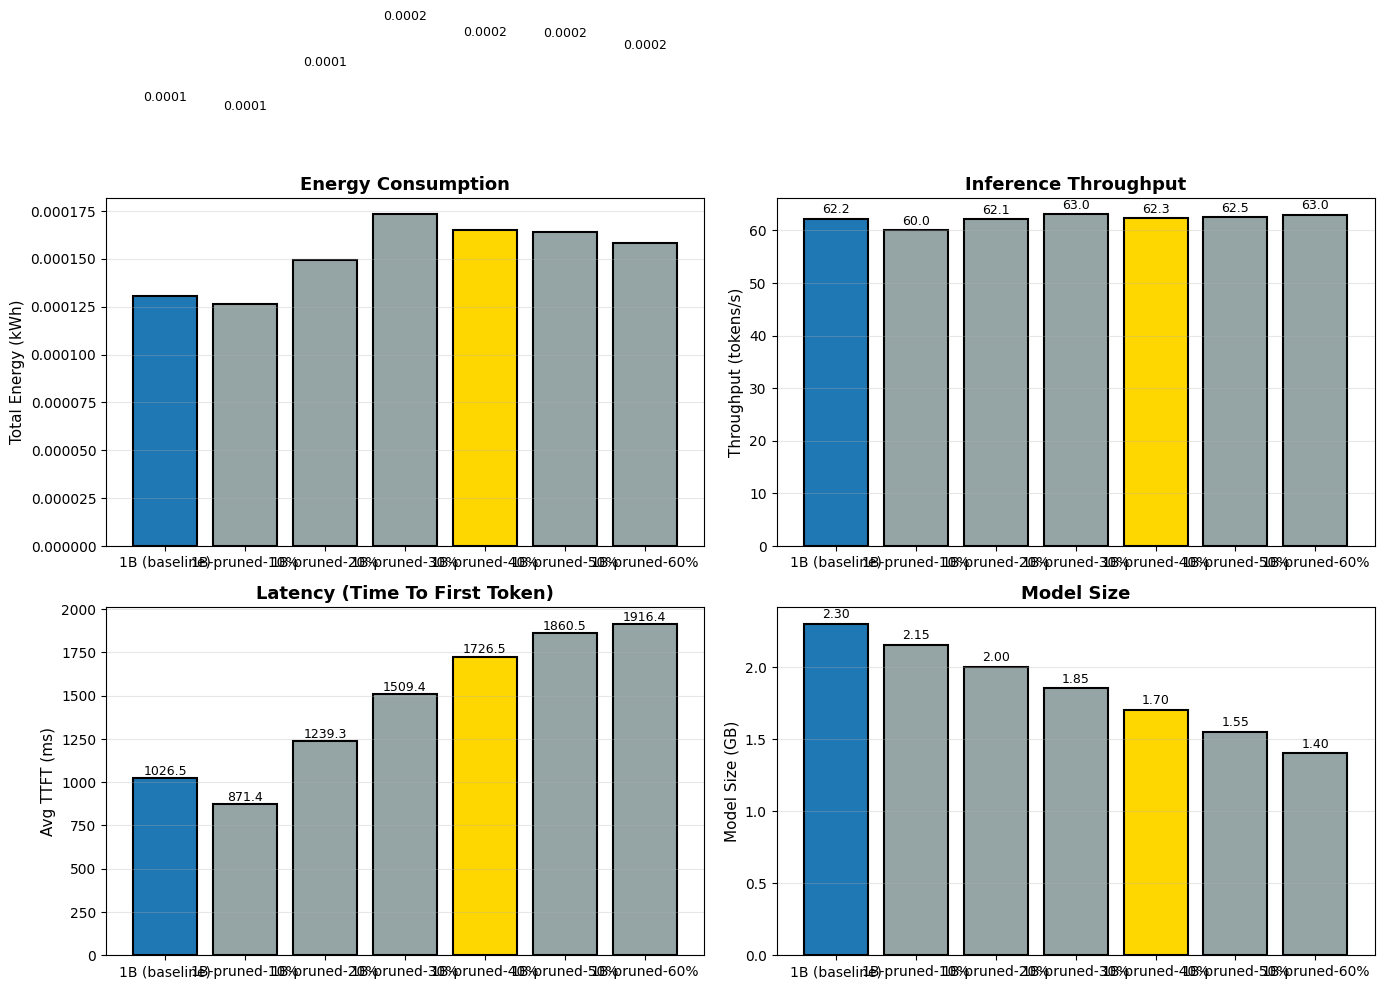


📊 Visualization saved to: /content/drive/MyDrive/glu_pruning/results/carbon_1b_analysis.png


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = summary_df['model'].values
pruning_levels = summary_df['pruning_pct'].values
star_mask = summary_df['is_star'].values

# Colors: baseline blue, star gold, others gray
colors = ['#1f77b4' if p == 0 else '#FFD700' if s else '#95a5a6'
          for p, s in zip(pruning_levels, star_mask)]

# 1. Energy Consumption
axes[0, 0].bar(range(len(models)), summary_df['total_energy_kwh'], color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_xticks(range(len(models)))
axes[0, 0].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[0, 0].set_ylabel('Total Energy (kWh)', fontsize=11)
axes[0, 0].set_title('Energy Consumption', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['total_energy_kwh']):
    axes[0, 0].text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# 2. Throughput
axes[0, 1].bar(range(len(models)), summary_df['avg_throughput_tok_s'], color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_xticks(range(len(models)))
axes[0, 1].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[0, 1].set_ylabel('Throughput (tokens/s)', fontsize=11)
axes[0, 1].set_title('Inference Throughput', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['avg_throughput_tok_s']):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 3. Latency (TTFT)
axes[1, 0].bar(range(len(models)), summary_df['avg_ttft_ms'], color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xticks(range(len(models)))
axes[1, 0].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[1, 0].set_ylabel('Avg TTFT (ms)', fontsize=11)
axes[1, 0].set_title('Latency (Time To First Token)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['avg_ttft_ms']):
    axes[1, 0].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 4. Model Size
axes[1, 1].bar(range(len(models)), summary_df['model_size_gb'], color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xticks(range(len(models)))
axes[1, 1].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[1, 1].set_ylabel('Model Size (GB)', fontsize=11)
axes[1, 1].set_title('Model Size', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['model_size_gb']):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/carbon_1b_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Visualization saved to: {RESULTS_DIR}/carbon_1b_analysis.png")

# 7. Agregating results.

In [23]:
# NUEVO CÓDIGO PARA LA CELDA 42

import os
import json
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path

print(f"\n{'='*70}")
print("📊 CONSTRUCTING FINAL JSON FROM AGGREGATED RESULTS")
print(f"{'='*70}\n")

# --- Validar variables globales ---
# (Asegurarse de que las variables de celdas anteriores existen)

if 'RESULTS_DIR' not in globals():
    print("⚠️ Warning: RESULTS_DIR not set. Using default './results'")
    RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

if 'BENCHMARKS_CARBON' not in globals():
    print("❌ Error: BENCHMARKS_CARBON not defined. Recargando fallback.")
    BENCHMARKS_CARBON = [
        {"name": "gsm8k_latency_b1", "num_prompts": 10, "max_new_tokens": 100, "dataset": "gsm8k", "subset": "test", "description": "Math reasoning (Latency, TTFT, bsz=1)", "batch_size": 1},
        {"name": "mmlu_latency_b1", "num_prompts": 10, "max_new_tokens": 50, "dataset": "mmlu", "subset": "test", "description": "Knowledge QA (Latency, TTFT, bsz=1)", "batch_size": 1},
        {"name": "ifeval_latency_b1", "num_prompts": 10, "max_new_tokens": 150, "dataset": "IFEval", "subset": "train", "description": "Instruction (Latency, TTFT, bsz=1)", "batch_size": 1},
        {"name": "gsm8k_throughput_b8", "num_prompts": 10, "max_new_tokens": 100, "dataset": "gsm8k", "subset": "test", "description": "Math reasoning (Throughput, bsz=8)", "batch_size": 8},
        {"name": "mmlu_throughput_b8", "num_prompts": 10, "max_new_tokens": 50, "dataset": "mmlu", "subset": "test", "description": "Knowledge QA (Throughput, bsz=8)", "batch_size": 8},
        {"name": "ifeval_throughput_b8", "num_prompts": 10, "max_new_tokens": 150, "dataset": "IFEval", "subset": "train", "description": "Instruction (Throughput, bsz=8)", "batch_size": 8},
    ]

# --- Usar resultados ya agregados y filtrados ---
if 'aggregated_results' not in globals() or 'all_results' not in globals():
    print("❌ FATAL ERROR: 'aggregated_results' o 'all_results' no están definidos.")
    print("   Por favor, ejecute de nuevo las celdas 38 y 39 antes de esta.")
else:
    print(f"Usando 'aggregated_results' (calculados en Celda 39) para {len(aggregated_results)} modelos.")

    # --- Construir el JSON Completo ---

    # 1. Construir mapeo de configuración
    config_map = {}
    model_family_name = "Llama-3.2-1B"

    for cfg in EXPERIMENT_CONFIG_CARBON:
        if model_family_name not in cfg["base_model"]:
            continue

        pruning_pct = cfg['pruning_pct']
        # La clave debe coincidir con la usada en 'aggregated_results' (p.ej. 'baseline', '20pct', '40pct')
        key = "baseline" if pruning_pct == 0 else f"{pruning_pct}pct"
        model_name_cfg = f"{model_family_name}" if pruning_pct == 0 else f"{model_family_name}-pruned-{pruning_pct}%"

        hf_repo = cfg.get("hf_repo_id", cfg["base_model"]) if pruning_pct > 0 else cfg["base_model"]

        config_map[key] = {
            "name": model_name_cfg,
            "pruning_pct": int(pruning_pct),
            "is_star": bool(cfg["is_star"]),
            "hf_repo": hf_repo,
        }

    print(f"\nDynamically built config map for {len(config_map)} models.")

    # 2. Construir 'models_evaluated'
    models_evaluated = {}
    summary_stats_list = []

    for model_key, workload_results in aggregated_results.items():
        if model_key in config_map:
            config = config_map[model_key]

            # Usar los resultados de workload_results (ya filtrados por outliers)
            models_evaluated[model_key] = {
                "name": config["name"],
                "pruning_pct": config["pruning_pct"],
                "is_star": config["is_star"],
                "hf_repo": config["hf_repo"],
                "results": workload_results
            }

            # Calcular estadísticas de resumen (basado en Celda 40)
            valid_workloads = [w for w in workload_results.values() if 'error' not in w]
            if valid_workloads:
                joules_per_token_values = [m['joules_per_token_mean'] for m in valid_workloads if m.get('joules_per_token_mean') is not None]
                avg_joules_per_token = float(np.mean(joules_per_token_values)) if joules_per_token_values else 0.0
                ttft_values = [m['ttft_mean'] for m in valid_workloads if m.get('ttft_mean') is not None]
                avg_ttft = float(np.mean(ttft_values)) if ttft_values else 0.0

                summary_stats_list.append({
                    "model": config["name"],
                    "pruning_pct": config["pruning_pct"],
                    "is_star": config["is_star"],
                    "total_energy_kwh": sum(m.get('energy_kwh_mean', 0) for m in valid_workloads),
                    "avg_throughput_tok_s": np.mean([m.get('throughput_mean', 0) for m in valid_workloads]),
                    "avg_joules_per_token": avg_joules_per_token,
                    "avg_ttft_ms": avg_ttft,
                    "model_size_gb": list(valid_workloads)[0].get('model_size_gb', 0)
                })
        else:
            print(f"⚠️ Warning: No config map entry found for key '{model_key}'.")

    # 3. Construir 'summary_statistics'
    baseline_stats = next((s for s in summary_stats_list if s['pruning_pct'] == 0), None)
    pruned_stats = sorted([s for s in summary_stats_list if s['pruning_pct'] > 0], key=lambda x: x['pruning_pct'])

    summary_statistics = {
        "baseline": baseline_stats,
        "pruned_models": pruned_stats
    }

    # 4. Obtener hardware_info (del primer run del baseline, usando 'all_results')
    hardware_info = {}
    try:
        if "baseline" in all_results and "run_1_seed_42" in all_results["baseline"]:
            first_workload_data = list(all_results["baseline"]["run_1_seed_42"].values())[0]
            if "hardware_metadata" in first_workload_data:
                hardware_info = first_workload_data["hardware_metadata"]
                print(f"    Captured hardware metadata (GPU: {hardware_info.get('gpu_name_torch', 'N/A')})")
    except Exception as e:
        print(f"    Could not extract hardware info: {e}")


    # 5. Consolidar todo
    complete_results = {
        "experiment_metadata": {
            "timestamp": datetime.now().isoformat(),
            "notebook": "03_Evaluate_1B_CARBON.ipynb",
            "model_family": model_family_name,
            "pruning_method": "MAW (Maximum Absolute Weight)",
            "hardware_details": hardware_info
        },
        "benchmarks": [
            {
                "name": task["name"],
                "num_prompts": task["num_prompts"],
                "max_new_tokens": task["max_new_tokens"],
                "description": task["description"]
            }
            for task in BENCHMARKS_CARBON
        ],
        "models_evaluated": models_evaluated,
        "summary_statistics": summary_statistics,
        "citation": {
            "paper": "Exploring GLU Expansion Ratios: Structured Pruning in Llama-3.2 Models",
            "author": "Pere Martra",
            "doi": "https://doi.org/10.31219/osf.io/qgxea",
            "github": "https://github.com/peremartra/llama-glu-expansion-pruning",
            "note": "Results are freely available for research purposes. Please cite the paper if you use this data."
        }
    }
    print(f"\nSuccessfully consolidated results for {len(models_evaluated)} models.")

    # --- Guardar en JSON ---
    try:
        os.makedirs(RESULTS_DIR, exist_ok=True)

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        json_path = f"{RESULTS_DIR}/llama_1b_carbon_complete_results_{timestamp}.json"
        with open(json_path, 'w') as f:
            json.dump(complete_results, f, indent=2, ensure_ascii=False, default=str)

        print(f"\n✅ Complete (and filtered) carbon results saved to:")
        print(f"   {json_path}")

        latest_json = f"{RESULTS_DIR}/llama_1b_carbon_complete_results_latest.json"
        with open(latest_json, 'w') as f:
            json.dump(complete_results, f, indent=2, ensure_ascii=False, default=str)

        print(f"✅ Latest (and filtered) version:")
        print(f"   {latest_json}")

        file_size_kb = Path(json_path).stat().st_size / 1024
        print(f"\n📊 File size: {file_size_kb:.1f} KB")

    except Exception as e:
        print(f"❌ Error saving JSON files: {e}")

    print(f"\n{'='*70}")
    print("✅ COMPLETE CARBON RESULTS SAVED - Ready for research sharing")
    print(f"{'='*70}\n")


📊 CONSTRUCTING FINAL JSON FROM AGGREGATED RESULTS

Usando 'aggregated_results' (calculados en Celda 39) para 7 modelos.

Dynamically built config map for 7 models.

Successfully consolidated results for 7 models.

✅ Complete (and filtered) carbon results saved to:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_carbon_complete_results_20251106_221418.json
✅ Latest (and filtered) version:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_carbon_complete_results_latest.json

📊 File size: 77.2 KB

✅ COMPLETE CARBON RESULTS SAVED - Ready for research sharing



---

## 🎓 Key Takeaways

This notebook evaluated the Llama-3.2-1B model family across 10 comprehensive benchmarks to determine:

1. **Optimal pruning level** for GLU-MLP layers
2. **Performance-efficiency trade-offs** at different expansion ratios
3. **Which models justify upload** to HuggingFace Hub


---

**Powered by OptiPFair** - Structured Pruning for GLU Architectures

If this research helps your work:
- ⭐ Star [the repo](https://github.com/peremartra/optipfair)
- 📖 Read the [documentation](https://peremartra.github.io/optipfair/)
- 🐛 Report issues or suggest features

---